### Import modules

In [1]:
import pandas as pd

from diamondminer.miner import *

%matplotlib inline

### Load Data

First you need to load your data; here is an example demo dataset.

> Note: Data is assumed to be clean and cropped so that it zooms into diamonds of interest.

In [2]:
# Load the data from the txt file
demo_data_loaded = pd.read_csv('demo_data_2.txt', sep='\t', index_col=0)

# Convert the loaded data back to numpy arrays if needed
P_data = demo_data_loaded.columns.to_numpy().astype(float)
S_data = demo_data_loaded.index.to_numpy().astype(float)
I_data = demo_data_loaded.to_numpy().astype(float)

### Extract Diamonds

Next step is to extract the diamonds found in your data. The program does this by,

1. Breaking the data into two halfs: upper and lower.
2. Each half is used as input to the Hough transform.
3. Detected lines are then filtered for any duplicates and are sorted based on which section they belong
and whether their slope is positive or negative.
4. Finally, cluster the relevent lines together and "glue" them together to form our diamonds.

> Note: If the extraction isn't working, turn `debug=True` to plot any intermediate results. 
Adjust parameters found in `miner.filter_raw_data()`, `miner.extract_edges()`, `miner.extract_lines()` until lines are detected.

/Users/andrijapaurevic/miniforge3/envs/diamond-miner/lib/python3.10/site-packages/diamondminer/miner.py:153: RuntimeWarning: divide by zero encountered in log
  filtered_current_data = np.log(


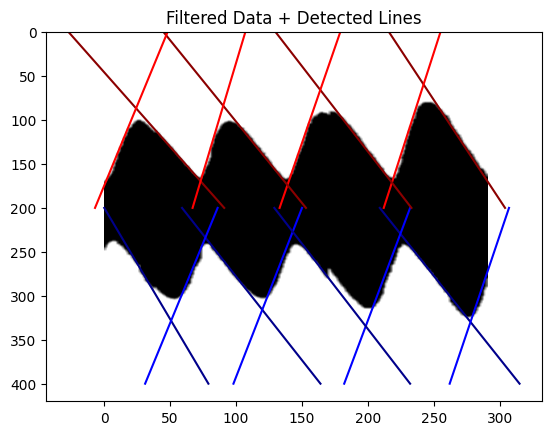

In [8]:
miner = Miner(
    gate_data=P_data, # Volts
    ohmic_data=S_data * 1e-3, # Volts
    current_data=I_data, # Ampheres
    # Material properties below are OPTIONAL!
    # They allow for the estimation of dot radius.
    epsR = 10.3, # Al2O3
    oxide_thickness = 20e-9 #nm
)
diamonds = miner.extract_diamonds(debug = True)

### Plotting the results!

Summary (#0):


Constants
---------
Elementary Charge (e): 1.60218e-19 C
Permittivity of Free Space (ϵ0): 8.85419e-12 F/m
Relative Permittivity (ϵR): 10.30000
Oxide Thickness: 0.00000 nm
---------


Geometry
---------
Left Vertex: [0.16786311 0.        ]
Top Vertex: [0.18034095 0.00128   ]
Right Vertex: [0.18657987 0.        ]
Bottom Vertex: [ 0.17385247 -0.00114   ]
Width: 0.01872 V
Height: 0.00242 V
---------


Dot Properties
--------------
Lever Arm (α): 0.06465 eV/V
Addition Voltage: 0.01872 V
Charging Voltage: 0.00121 V
Gate Capacitance: 8.56012 aF
Source Capacitance: 43.28745 aF
Drain Capacitance: 80.53705 aF
Total Capacitance: 132.41129 aF
Dot Radius: 96.14121 nm
--------------


Summary (#1):


Constants
---------
Elementary Charge (e): 1.60218e-19 C
Permittivity of Free Space (ϵ0): 8.85419e-12 F/m
Relative Permittivity (ϵR): 10.30000
Oxide Thickness: 0.00000 nm
---------


Geometry
---------
Left Vertex: [0.18657987 0.        ]
Top Vertex: [0.19756037 0.00115   ]
Right Vertex:

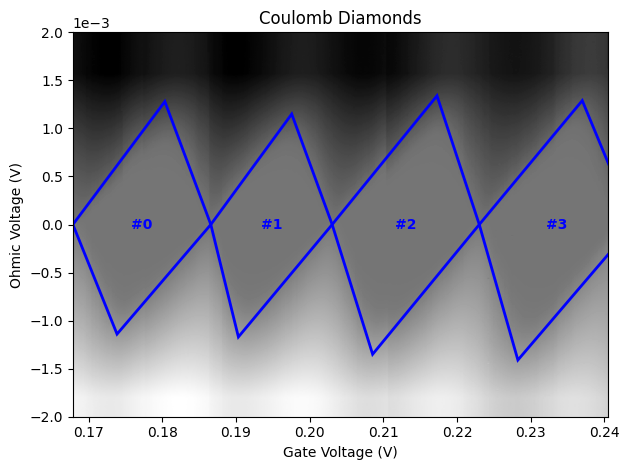

In [9]:
fig, ax = plt.subplots()
ax.imshow(
    miner.current_data, 
    cmap='binary',
    aspect='auto',
    origin='lower',
    extent=[
        miner.gate_data[0],
        miner.gate_data[-1], 
        miner.ohmic_data[0], 
        miner.ohmic_data[-1]
    ],
)
ax.set_title("Coulomb Diamonds")
ax.set_xlabel("Gate Voltage (V)")
ax.set_ylabel("Ohmic Voltage (V)")
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
for diamond in diamonds:
    diamond.print_summary()
    diamond.plot(ax)

plt.tight_layout()
plt.show()

In [10]:
statistics = miner.get_statistics()

Average Lever Arm (α) : 0.06671 (eV/V) ± 0.00061 (eV/V)
Average Addition Voltage: 0.01903 (V) ± 0.00042 (V)
Average Charging Voltage: 0.00127 (V) ± 0.00002 (V)
Average Total Capacitance: 127.08266 (aF) ± 2.10723 (aF)
Average Gate Capacitance: 8.48890 (aF) ± 0.19644 (aF)
Average Source Capacitance: 36.93351 (aF) ± 0.99120 (aF)
Average Drain Capacitance: 80.91908 (aF) ± 1.25416 (aF)
Average Dot Radius: 94.13525 (nm) ± 0.77927 (nm)


### Estimate Charge Temperature

Next step is to extract the temperature of your charges based on data found in the Coulomb diamonds. The program does this by,

1. Slicing the data at a specified user ohmic value (low bias regime)
2. Fit the Coulomb oscillation to the theoretical function (see ref [here](https://pubs.aip.org/aip/apl/article/120/18/184003/2833621/Wafer-scale-low-disorder-2DEG-in-28Si-SiGe-without)),

$$
I(V_G) = A + B \cosh^{-2}\left(\alpha\frac{V_0 - V}{2 k_B T}\right)
$$

where $A, B, V_0$ and $T$ are fit coefficients and $\alpha$ is the lever arm that comes from the Coulomb diamond data.

3. The average temperature is determined by averaging the results from the $N$ detected Coulomb oscillations,

$$
T = \mu_T \pm \frac{\sigma_T}{\sqrt{N}}
$$

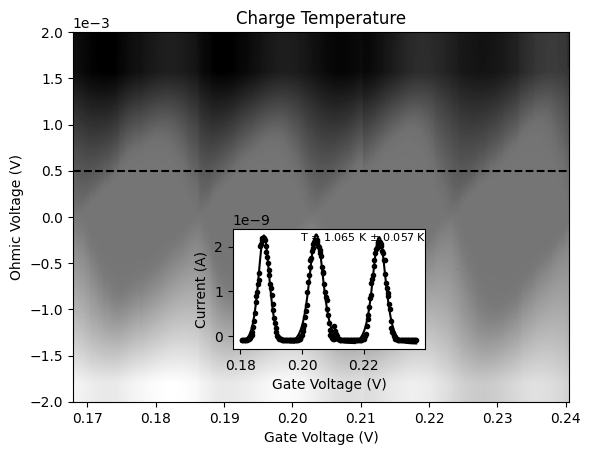

In [6]:
ohmic_value = 500e-6 # Volts

fig, ax = plt.subplots()
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.375, 0.22, 0.3, 0.25]
ax_inset = fig.add_axes([left, bottom, width, height])
ax.imshow(
    miner.current_data, 
    cmap='binary',
    aspect='auto',
    origin='lower',
    extent=[
        miner.gate_data[0],
        miner.gate_data[-1], 
        miner.ohmic_data[0], 
        miner.ohmic_data[-1]
    ],
)
ax.set_title("Charge Temperature")
ax.set_xlabel("Gate Voltage (V)")
ax.set_ylabel("Ohmic Voltage (V)")
ax.axhline(ohmic_value, c='k', linestyle="--")
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

temperatures = miner.estimate_temperatures(diamonds, ohmic_value, axes=ax_inset)

plt.show()